In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GAN import *

In [2]:
import torch
import torch.nn.functional as F
from dataloader import TimeDataset
from torch.utils.data import Dataset, DataLoader

In [3]:
X=np.load("data.npy")
labels=np.load("label.npy").reshape(1,-1)
num_classes = len(np.unique(labels))
one_hot_labels = np.zeros((labels.size, num_classes), dtype=int)
one_hot_labels[np.arange(labels.size), labels] = 1

In [4]:
#dataloader
dataset = TimeDataset(X[0:int(0.75*len(X))], one_hot_labels[0:int(0.75*len(one_hot_labels))])
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
testX=X[int(0.75*len(X)):-1]
testy=one_hot_labels[int(0.75*len(one_hot_labels)):-1]

In [26]:
#参数
noise_dim=96
con_dim=7
output_dim=96
num_epochs=1000
lr=0.001

In [27]:
g=Generator(noise_dim,con_dim,output_dim)
d=Discriminator(output_dim,con_dim)
optimizer_G = optim.Adam(g.parameters(), lr=lr)
optimizer_D = optim.Adam(d.parameters(), lr=lr)
criterion = nn.BCELoss()

In [28]:
for epoch in range(num_epochs):
    for real_data, labels in dataloader:
        batch_size = real_data.size(0)
        
        # 标签转换为独热编码
        real_condition = labels
        
        # 真实和虚假标签
        valid = torch.ones(batch_size, 1)
        fake = torch.zeros(batch_size, 1)
        
        #真实样本训练判别器
        real_output = d(real_data, real_condition)
        #print(real_output.shape)
        loss_real = criterion(real_output, valid)
        optimizer_D.zero_grad()
        loss_real.backward()
        optimizer_D.step()

        #生成样本训练判别器
        noise = torch.randn(batch_size, noise_dim)
        fake_data = g(noise, real_condition)
        fake_output = d(fake_data.detach(), real_condition)
        loss_fake = criterion(fake_output, fake)
        optimizer_D.zero_grad()
        loss_fake.backward()
        optimizer_D.step()
        
        # 训练生成器
        fake_output = d(fake_data, real_condition)
        loss_G = criterion(fake_output, valid)
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        #break
        
        # 打印训练进度
        if epoch % 10 ==0:
            print(f"Epoch [{epoch}/{num_epochs}] | Loss D: {loss_fake.item():.4f} | Loss G: {loss_G.item():.4f}")

In [15]:

# 设置测试参数
num_samples = len(testy)  
noise_dim = 96
num_labels = 7

g.eval()
with torch.no_grad():
    
    #test_labels = torch.randint(1, 8, (num_samples,))
    test_conditions=torch.tensor(testy)
    noise = torch.randn(num_samples, noise_dim)
    #test_conditions = F.one_hot(test_labels - 1, num_labels).float()
    generated_data = g(noise, test_conditions)
    generated_data = generated_data.view(num_samples, 96)

    # 打印或可视化生成的数据
    # for i in range(num_samples):
    #     print(f"Generated data for label {test_labels[i].item()}:")
    #     print(generated_data[i].squeeze().cpu().numpy())
    #     print("\n")

In [16]:
def mean_absolute_error(y_true, y_pred):
    "mae"
    return np.mean(np.abs(y_true - y_pred))


0.7702991001395276
0.8082842605488576
0.8356487143216024
0.774318148207044
0.8060146463609389
0.8043423262414577
0.784605483058412


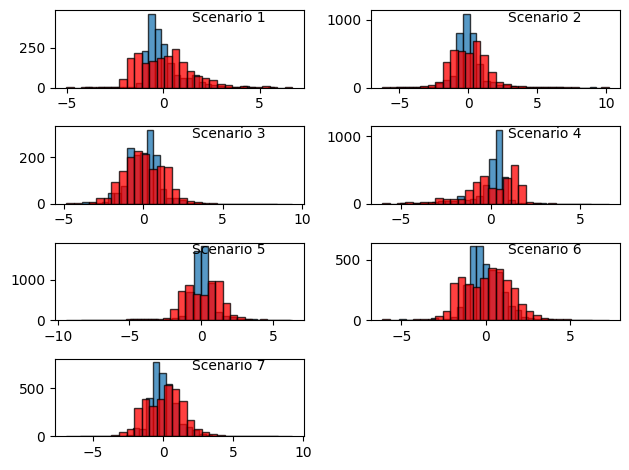

In [25]:
for yi in range(7):
    test_labels=np.load("label.npy").reshape(-1,)[-int(0.25*960):-1]
    indices = np.where(test_labels == yi)[0]
    mae=mean_absolute_error(np.array(testX[indices, :].T),np.array(generated_data[indices, :].T))
    print(mae)
    #分布直方图
    plt.subplot(4,2,yi+1)
    plt.hist(np.array(testX[indices, :].T).reshape(-1,), bins=30, alpha=0.75, color="#1f77b4", edgecolor='black')
    plt.hist(np.array(generated_data[indices, :].T).reshape(-1,), bins=30, alpha=0.75, color='red', edgecolor='black')
    plt.text(0.55, 0.85,'Scenario %d' % (yi + 1),transform=plt.gca().transAxes)


plt.tight_layout()
plt.savefig("result.pdf")